In [1]:
import numpy as np
import torchvision
import torch
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
torch.cuda.is_available()

True

In [3]:
# set up logging
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)

In [4]:
# make deterministic
from imggpt.utils import set_seed
set_seed(42)


In [5]:
# pytorch helpfully makes it easy to download datasets, e.g. the common CIFAR-10 https://www.kaggle.com/c/cifar-10
root = './'
train_data = torchvision.datasets.CIFAR10(root, train=True, transform=None, target_transform=None, download=True)
test_data  = torchvision.datasets.CIFAR10(root, train=False, transform=None, target_transform=None, download=True)
print(len(train_data), len(test_data))

Files already downloaded and verified
Files already downloaded and verified
50000 10000


In [6]:
# get random 5 pixels per image and stack them all up as rgb values to get half a million random pixels
pluck_rgb = lambda x: torch.from_numpy(np.array(x)).view(32*32, 3)[torch.randperm(32*32)[:5], :]
px = torch.cat([pluck_rgb(x) for x, y in train_data], dim=0).float()
print(px.size())

torch.Size([250000, 3])


In [7]:
# run kmeans to get our codebook

def kmeans(x, ncluster, niter=10):
    N, D = x.size()
    c = x[torch.randperm(N)[:ncluster]] # init clusters at random
    for i in range(niter):
        # assign all pixels to the closest codebook element
        a = ((x[:, None, :] - c[None, :, :])**2).sum(-1).argmin(1)
        # move each codebook element to be the mean of the pixels that assigned to it
        c = torch.stack([x[a==k].mean(0) for k in range(ncluster)])
        # re-assign any poorly positioned codebook elements
        nanix = torch.any(torch.isnan(c), dim=1)
        ndead = nanix.sum().item()
        print('done step %d/%d, re-initialized %d dead clusters' % (i+1, niter, ndead))
        c[nanix] = x[torch.randperm(N)[:ndead]] # re-init dead clusters
    return c

ncluster = 512
with torch.no_grad():
    C = kmeans(px, ncluster, niter=8)

print(C.size())

done step 1/8, re-initialized 4 dead clusters
done step 2/8, re-initialized 0 dead clusters
done step 3/8, re-initialized 0 dead clusters
done step 4/8, re-initialized 0 dead clusters
done step 5/8, re-initialized 0 dead clusters
done step 6/8, re-initialized 0 dead clusters
done step 7/8, re-initialized 0 dead clusters
done step 8/8, re-initialized 0 dead clusters
torch.Size([512, 3])


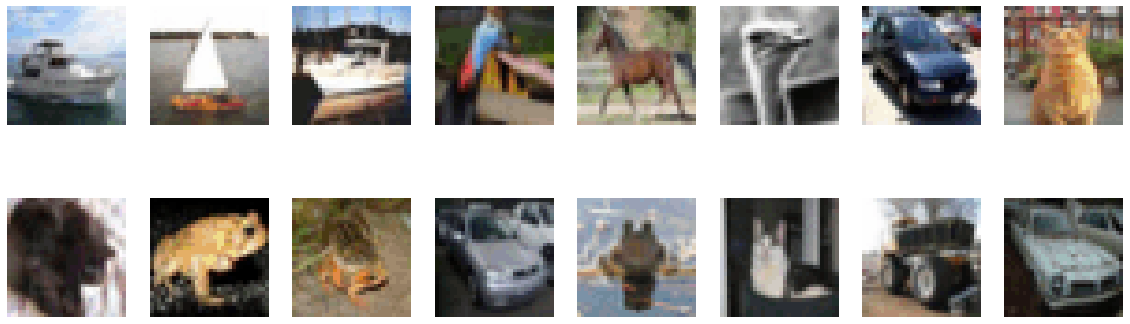

In [8]:
# encode the training examples with our codebook to visualize how much we've lost in the discretization
n_samples = 16
ncol = 8
nrow = n_samples // ncol + 1
plt.figure(figsize=(20, 10))
for i in range(n_samples):
    
    # encode and decode random data
    x, y = train_data[np.random.randint(0, len(train_data))]
    xpt = torch.from_numpy(np.array(x)).float().view(32*32, 3)
    ix = ((xpt[:, None, :] - C[None, :, :])**2).sum(-1).argmin(1) # cluster assignments for each pixel
    
    # these images should look normal ideally
    plt.subplot(nrow, ncol, i+1)
    plt.imshow(C[ix].view(32, 32, 3).numpy().astype(np.uint8))
    plt.axis('off')

In [8]:
from torch.utils.data import Dataset

class ImageDataset(Dataset):
    """
    wrap up the pytorch CIFAR-10 dataset into our own, which will convert images into sequences of integers
    """
    
    def __init__(self, pt_dataset, clusters, perm=None):
        self.pt_dataset = pt_dataset
        self.clusters = clusters
        self.perm = torch.arange(32*32) if perm is None else perm
        
        self.vocab_size = clusters.size(0)
        self.block_size = 32*32 - 1
        
    def __len__(self):
        return len(self.pt_dataset)

    def __getitem__(self, idx):
        x, y = self.pt_dataset[idx]
        x = torch.from_numpy(np.array(x)).view(-1, 3) # flatten out all pixels
        x = x[self.perm].float() # reshuffle pixels with any fixed permutation and -> float
        a = ((x[:, None, :] - self.clusters[None, :, :])**2).sum(-1).argmin(1) # cluster assignments
        return a[:-1], a[1:] # always just predict the next one in the sequence

train_dataset = ImageDataset(train_data, C)
test_dataset = ImageDataset(test_data, C)
train_dataset[0][0] # one example image flattened out into integers


tensor([449, 229, 229,  ..., 379,   0, 177])

In [22]:
"The size of An image unrolled into a single dimensional vector"
len(train_dataset[0][0])

1023

In [9]:
from imggpt.model import GPT, GPTConfig, GPT1Config

# we'll do something a bit smaller
mconf = GPTConfig(train_dataset.vocab_size, train_dataset.block_size,
                  embd_pdrop=0.0, resid_pdrop=0.0, attn_pdrop=0.0,
                  n_layer=6, n_head=4, n_embd=32)
model = GPT(mconf)


05/01/2022 23:28:47 - INFO - imggpt.model -   number of parameters: 1.417920e+05


In [11]:
from imggpt.trainer import Trainer, TrainerConfig

tokens_per_epoch = len(train_data) * train_dataset.block_size
train_epochs = 10 # todo run a bigger model and longer, this is tiny

# initialize a trainer instance and kick off training
tconf = TrainerConfig(max_epochs=train_epochs, batch_size=20, learning_rate=3e-3,
                      betas = (0.9, 0.95), weight_decay=0,
                      lr_decay=True, warmup_tokens=tokens_per_epoch, final_tokens=train_epochs*tokens_per_epoch,
                      ckpt_path='cifar10_model.pt')
trainer = Trainer(model, train_dataset, test_dataset, tconf)
trainer.train()


epoch 1 iter 2499: train loss 2.70781. lr 3.000000e-03: 100%|███| 2500/2500 [33:56<00:00,  1.23it/s]
04/30/2022 21:31:18 - INFO - imggpt.trainer -   test loss: 2.699112
04/30/2022 21:31:18 - INFO - imggpt.trainer -   saving cifar10_model.pt
epoch 2 iter 2499: train loss 2.57972. lr 2.909539e-03: 100%|███| 2500/2500 [33:35<00:00,  1.24it/s]
04/30/2022 22:07:59 - INFO - imggpt.trainer -   test loss: 2.468270
04/30/2022 22:07:59 - INFO - imggpt.trainer -   saving cifar10_model.pt
epoch 3 iter 2499: train loss 2.45628. lr 2.649067e-03: 100%|███| 2500/2500 [34:00<00:00,  1.23it/s]
04/30/2022 22:45:05 - INFO - imggpt.trainer -   test loss: 2.359000
04/30/2022 22:45:05 - INFO - imggpt.trainer -   saving cifar10_model.pt
epoch 4 iter 2499: train loss 2.24201. lr 2.250000e-03: 100%|███| 2500/2500 [33:44<00:00,  1.24it/s]
04/30/2022 23:21:55 - INFO - imggpt.trainer -   test loss: 2.296173
04/30/2022 23:21:55 - INFO - imggpt.trainer -   saving cifar10_model.pt
epoch 5 iter 2499: train loss 2.2515

In [10]:
# load the state of the best model we've seen based on early stopping
checkpoint = torch.load('cifar10_model.pt')
model.load_state_dict(checkpoint)

<All keys matched successfully>

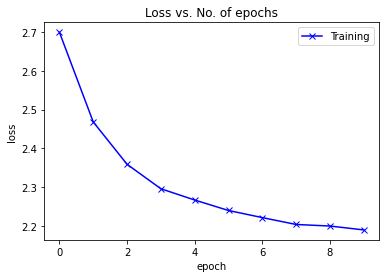

In [23]:
train_loss=[2.699, 2.468, 2.359, 2.296, 2.267, 2.240, 2.2217, 2.204, 2.200, 2.190]
plt.plot(train_loss, '-bx')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss vs. No. of epochs');

In [24]:
counts = torch.ones(ncluster) # start counts as 1 not zero, this is called "smoothing"
rp = torch.randperm(len(train_dataset))
nest = 5000 # how many images to use for the estimation
for i in range(nest):
    a, _ = train_dataset[int(rp[i])]
    t = a[0].item() # index of first token in the sequence
    counts[t] += 1
prob = counts/counts.sum()

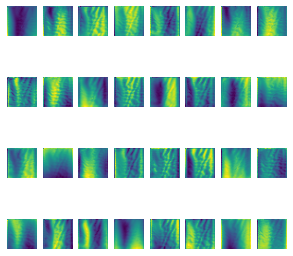

In [32]:


# visualize some of the learned positional embeddings, maybe they contain structure
plt.figure(figsize=(5, 5))
nsee = 8*4
ncol = 8
nrow = nsee // ncol
for i in range(nsee):
    
    ci = model.pos_emb.data[0, :, i].cpu()
    zci = torch.cat((torch.tensor([0.0]), ci)) # pre-cat a zero
    rzci = zci[iperm] # undo the permutation to recover the pixel space of the image
    
    plt.subplot(nrow, ncol, i+1)
    plt.imshow(rzci.view(32, 32).numpy())
    plt.axis('off')

